In [20]:
import os
import geopandas as gpd
import numpy as np
import pandas as pd
import seaborn as sb

# data preparation

### assigning a percentage of the gap area to a tree ID  

In [2]:
NORTH_PATH = './data/correlation_data/mgr - do analizy/North'
SOUTH_PATH = './data/correlation_data/mgr - do analizy/South'

In [3]:
def folder_names(path):
    
    folders = []
    folders = [f for f in sorted(os.listdir(path))]
    
    return folders

In [4]:
def names_of_files_in_directory(path):

    files=[]
    files = [f for f in sorted(os.listdir(path)) if f.endswith('.shp')]
   
    return files

In [5]:
def number_of_erase_shapefiles(files):
    count = 0

    for element in files:
        list_x = element.split('_')
        if len(list_x) == 4:
            count += 1
            
    return count

In [6]:
def create_result_df(path):

    for folder_name in folder_names(path):
        year = str(folder_name.split('_')[-2])
        files = names_of_files_in_directory(path + '/' + folder_name)
        number_of_files = number_of_erase_shapefiles(files)
        export_path = path[:-5] + '/Results/' + path[-5:] +  '/' + year + '.csv'

        data = {}

        for i in range(number_of_files):
            file_path = path + '/' + folder_name + '/' + 'martwe_drzewa_' + year + '_Erase' + str(i) + '_CLIP_' + year + '.shp'
            df = gpd.read_file(file_path)
            return df
            break
            
            data[i] = (df['area_x'].sum() / 157.08) * 100

        export_df = pd.DataFrame(data.items(), columns=['ID', 'area'])
        export_df.to_csv(path_or_buf = export_path)


In [7]:
# create_result_df(NORTH_PATH)
# create_result_df(SOUTH_PATH)

### assigning the diameter at breast height to a tree based on the tree number and ID

In [8]:
PATH2 = './data/correlation_data/mgr - do analizy/Spatial joins results'
PATH3 = './data/correlation_data/mgr - do analizy/Results/North'
PATH4 = './data/correlation_data/mgr - do analizy/Results/South'

In [9]:
dbh_dead = pd.read_excel(r'./data/Martwe pnie od 2014.xls')
dbh_dead = dbh_dead[dbh_dead[' pi'].astype(str).str.isdigit()]
dbh_dead.rename(columns = {' pi':'Pierśnica'}, inplace = True)
dbh_dead.head()

,numer,kwa,Unnamed: 2,ka,Pierśnica,Rok,Uwagi,kategorie:,1 - stojące
5,6002.0,80,NaN,2,65,2014,NaN,NaN,NaN
6,6004.0,87.88,NaN,2,50,2014,NaN,NaN,NaN
7,6006.0,87.88,NaN,2,39,2014,NaN,NaN,NaN
8,6008.0,101.102,NaN,2,49,2014,NaN,NaN,NaN
9,6011.0,94.95,NaN,1,36,2014,NaN,NaN,NaN


In [10]:
def assign_stand_gaps(df, year):

    north_path = PATH3 + '/' + str(year) + '.csv'
    gap_file = pd.read_csv(north_path)
    gap_file.rename(columns = {'area': 'north_gap'}, inplace = True)

    df = df.merge(gap_file, left_on = 'ORIG_FID', right_on = 'ID')

    return df

In [11]:
def assign_dbh_to_number(year, intensity_of_dying ,assign_dbh: bool = False):
    
    file_path = '{}/{}.shp'.format(PATH2, year)
    df = gpd.read_file(file_path)
    df.rename(columns = {'areasol_19': 'AreaSol_19', 'piersnica': 'Pierśnica'}, inplace = True)
    
    if assign_dbh:
        try:
            df = df.merge(dbh_dead, left_on = 'Numer', right_on = 'numer')
        except:
            df = df.merge(dbh_dead, left_on = 'numer', right_on = 'numer')
            
    df = assign_stand_gaps(df, year)

    if year == 2014: df['NEAR_DIST'] = 0    
    df = df[['layer_name', 'AreaSol_19', 'NEAR_DIST' ,'Pierśnica', 'north_gap']]
    df['Pierśnica'] = pd.to_numeric(df['Pierśnica'])
    df['gęstość'] = intensity_of_dying
    df.replace(0, np.nan, inplace=True)
        
    return df

In [12]:
years_2014_2022 = [
    assign_dbh_to_number(2014, 6.180556, True),
    assign_dbh_to_number(2015, 8.125000, True),
    assign_dbh_to_number(2016, 7.569444, True),
    assign_dbh_to_number(2017, 5.694444, True),
    assign_dbh_to_number(2018, 4.791667),
    assign_dbh_to_number(2019, 1.736111),
    assign_dbh_to_number(2020, 1.875000),
    #assign_dbh_to_number(2021, 2.430556),
    assign_dbh_to_number(2022, 2.638889)]

years_2014_2018 = [
    assign_dbh_to_number(2014, 6.180556, True),
    assign_dbh_to_number(2015, 8.125000, True),
    assign_dbh_to_number(2016, 7.569444, True),
    assign_dbh_to_number(2017, 5.694444, True),
    assign_dbh_to_number(2018, 4.791667)]

years_2019_2022 = [
    assign_dbh_to_number(2019, 1.736111),
    assign_dbh_to_number(2020, 1.875000),
    #assign_dbh_to_number(2021, 2.430556),
    assign_dbh_to_number(2022, 2.638889)]

df_2014_2022 = pd.concat(years_2014_2022, axis = 0)
df_2014_2018 = pd.concat(years_2014_2018, axis = 0)
df_2019_2022 = pd.concat(years_2014_2022, axis = 0)

In [16]:
pearson_df = df_2014_2022.iloc[:,1:].corr(method = 'pearson')
pearson_df

,AreaSol_19,NEAR_DIST,Pierśnica,north_gap,gęstość
AreaSol_19,1.000000,0.080363,-0.122345,-0.004179,-0.045897
NEAR_DIST,0.080363,1.000000,-0.039988,-0.094003,-0.004299
Pierśnica,-0.122345,-0.039988,1.000000,0.045012,0.000725
north_gap,-0.004179,-0.094003,0.045012,1.000000,-0.213060
gęstość,-0.045897,-0.004299,0.000725,-0.213060,1.000000


In [17]:
kendall_df = df_2014_2022.iloc[:,1:].corr(method = 'kendall')
kendall_df

,AreaSol_19,NEAR_DIST,Pierśnica,north_gap,gęstość
AreaSol_19,1.000000,0.058838,-0.085202,0.018559,-0.086627
NEAR_DIST,0.058838,1.000000,-0.013613,-0.068225,-0.032165
Pierśnica,-0.085202,-0.013613,1.000000,0.029025,0.027775
north_gap,0.018559,-0.068225,0.029025,1.000000,-0.160306
gęstość,-0.086627,-0.032165,0.027775,-0.160306,1.000000


In [18]:
spearman_df = df_2014_2022.iloc[:,1:].corr(method = 'spearman')
spearman_df

,AreaSol_19,NEAR_DIST,Pierśnica,north_gap,gęstość
AreaSol_19,1.000000,0.091099,-0.126358,0.026803,-0.120733
NEAR_DIST,0.091099,1.000000,-0.018151,-0.103780,-0.039994
Pierśnica,-0.126358,-0.018151,1.000000,0.043199,0.036573
north_gap,0.026803,-0.103780,0.043199,1.000000,-0.221980
gęstość,-0.120733,-0.039994,0.036573,-0.221980,1.000000


### correlation heatmaps

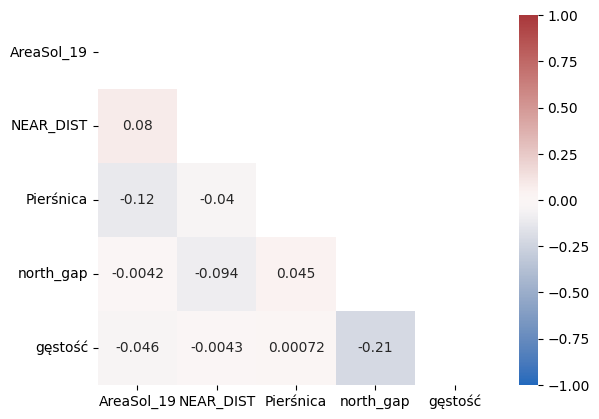

In [28]:
mask = np.triu(np.ones_like(pearson_df))
pearson_plot = sb.heatmap(pearson_df, cmap="vlag", annot=True, mask=mask, vmin=-1, vmax=1)

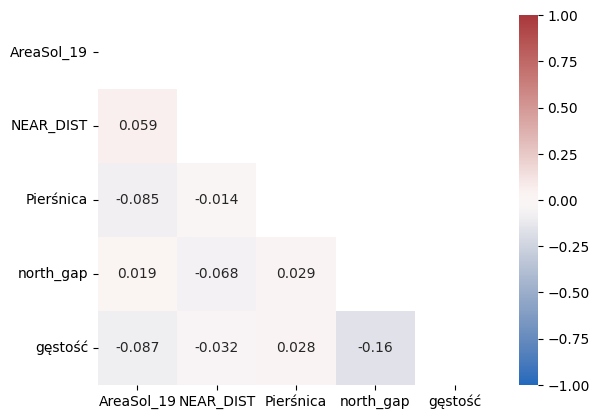

In [27]:
mask = np.triu(np.ones_like(kendall_df))
kendall_plot = sb.heatmap(kendall_df, cmap="vlag", annot=True, mask=mask, vmin=-1, vmax=1)

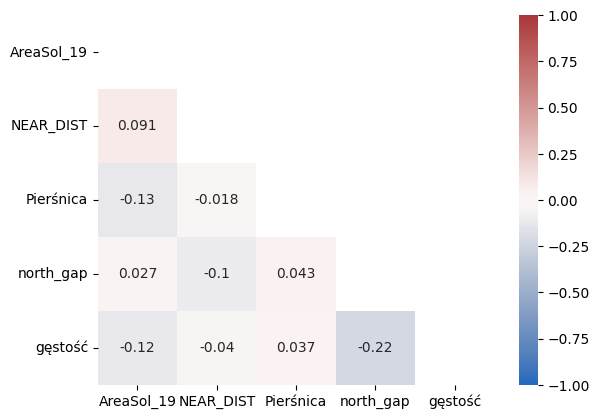

In [26]:
mask = np.triu(np.ones_like(spearman_df))
spearman_plot = sb.heatmap(spearman_df, cmap="vlag", annot=True, mask=mask, vmin=-1, vmax=1)